In [30]:
import torch
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
import numpy as np
from torchvision.utils import make_grid

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.to(device))
])
img_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device))
])
trn_ds = MNIST('.',transform = img_transform2, train=True, download=False)
val_ds = MNIST('.', transform=img_transform2, train=False, download=False)
batch_size = 64
trn_dl = DataLoader(trn_ds,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size, shuffle=False)

In [54]:
im, label = trn_ds[1]
im[0][4]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.6235, 0.9922,
        0.6235, 0.1961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0')

In [55]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()
        self.encode1 = nn.Linear(x_dim, h_dim1)
        self.encode2 = nn.Linear(h_dim1, h_dim2)
        self.bottleneck1 = nn.Linear(h_dim2, z_dim) # mean
        self.bottleneck2 = nn.Linear(h_dim2,z_dim) # variance/log(variance)
        self.decode1 = nn.Linear(z_dim, h_dim2)
        self.decode2 = nn.Linear(h_dim2, h_dim1)
        self.decode3 = nn.Linear(h_dim1, x_dim)
    
    def encoder(self, x):
        h = F.relu(self.encode1(x))
        h = F.relu(self.encode2(h))
        return self.bottleneck1(h), self.bottleneck2(h)

    def sample(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std) + (mean) # sample from latent space
    
    def decoder(self, z):
        h = F.relu(self.decode1(z))
        h = F.relu(self.decode2(h))
        h = self.decode3(h)
        return F.sigmoid(h)
    
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784)) # flatten + squeeze
        z = self.sample(mean, log_var)
        return self.decoder(z), mean, log_var

In [56]:
def train_batch(input, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    output, mean, log_var = model(input)
    loss, mse, kld = loss_fn(output, input, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def val_batch(input, model, loss_fn):
    model.eval()
    output, mean, log_var = model(input)
    loss, mse, kld = loss_fn(output, input, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()


In [57]:
def loss_fn(output, input, mean, log_var):
    mse = F.mse_loss(output, input.view(-1,784), reduction='sum')
    kld = -0.5 * \
        torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) # strength 0.5
    return mse + kld, mse, kld 
    

In [58]:
model = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

In [59]:
summary(model,torch.zeros(2,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 401,920
├─Linear: 1-2                            [-1, 256]                 131,328
├─Linear: 1-3                            [-1, 50]                  12,850
├─Linear: 1-4                            [-1, 50]                  12,850
├─Linear: 1-5                            [-1, 256]                 13,056
├─Linear: 1-6                            [-1, 512]                 131,584
├─Linear: 1-7                            [-1, 784]                 402,192
Total params: 1,105,780
Trainable params: 1,105,780
Non-trainable params: 0
Total mult-adds (M): 1.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 4.22
Estimated Total Size (MB): 4.24


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 401,920
├─Linear: 1-2                            [-1, 256]                 131,328
├─Linear: 1-3                            [-1, 50]                  12,850
├─Linear: 1-4                            [-1, 50]                  12,850
├─Linear: 1-5                            [-1, 256]                 13,056
├─Linear: 1-6                            [-1, 512]                 131,584
├─Linear: 1-7                            [-1, 784]                 402,192
Total params: 1,105,780
Trainable params: 1,105,780
Non-trainable params: 0
Total mult-adds (M): 1.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 4.22
Estimated Total Size (MB): 4.24

In [60]:
n_epochs = 15
log = Report(n_epochs)
N_train = len(trn_dl)
N_val = len(val_dl)

for epoch in range(n_epochs):
    for idx, (data, _) in enumerate(trn_dl):
        loss, mse, kld, log_var, mean = train_batch(data, model, optimizer,
                                                    loss_fn=loss_fn)
        position = epoch + (1+idx) / N_train
        log.record(position, train_loss=loss, train_kld = kld, 
                   train_mse = mse,train_log_var=log_var, train_mean=mean, 
                   end='\r')
    for idx, (data, _) in enumerate(val_dl):
        loss, mse, kld, log_var, mean = val_batch(data, model, loss_fn)
        position = epoch + (1+idx) / N_val
        log.record(position, val_loss=loss, val_kld=kld, val_mse=mse,
                   val_log_var=log_var, val_mean = mean, end='\r')
    log.report_avgs(epoch+1)

EPOCH: 1.000  val_mean: 0.001  train_mse: 2647.818  val_log_var: -0.277  train_loss: 2909.653  train_mean: 0.001  val_kld: 456.026  val_loss: 2347.332  train_kld: 261.835  val_mse: 1891.306  train_log_var: -0.158  (10.25s - 143.49s remaining)
EPOCH: 2.000  val_mean: 0.006  train_mse: 1727.010  val_log_var: -0.324  train_loss: 2215.055  train_mean: -0.000  val_kld: 537.213  val_loss: 2100.378  train_kld: 488.044  val_mse: 1563.165  train_log_var: -0.297  (20.38s - 132.49s remaining)
EPOCH: 3.000  val_mean: 0.005  train_mse: 1522.367  val_log_var: -0.355  train_loss: 2067.621  train_mean: -0.000  val_kld: 581.026  val_loss: 2017.142  train_kld: 545.254  val_mse: 1436.116  train_log_var: -0.335  (30.58s - 122.34s remaining)
EPOCH: 4.000  val_mean: 0.000  train_mse: 1420.339  val_log_var: -0.379  train_loss: 1996.139  train_mean: -0.000  val_kld: 608.020  val_loss: 1952.629  train_kld: 575.800  val_mse: 1344.609  train_log_var: -0.356  (40.76s - 112.09s remaining)
EPOCH: 5.000  val_mean: 0

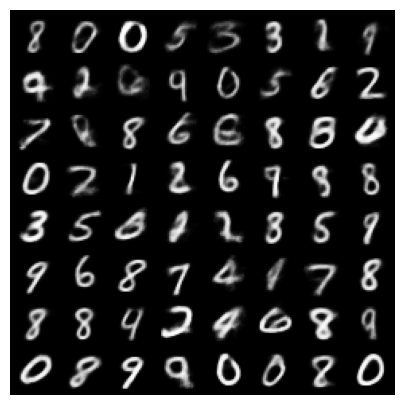

In [70]:
with torch.no_grad():
    z = torch.randn(64,50).to(device)
    sample = model.decoder(z).to(device)
    images = make_grid(sample.view(64,1,28,28))
    show(images)

100%|██████████| 116/116 [00:00<00:00, 513.62it/s]


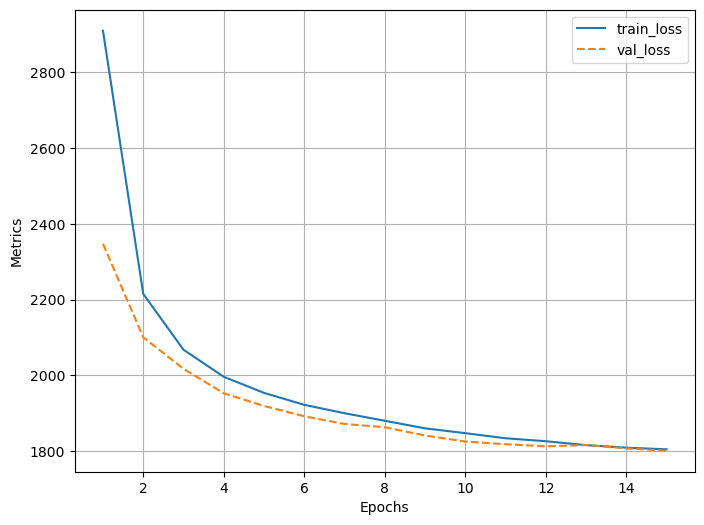

In [64]:
log.plot_epochs(['train_loss','val_loss'])